#Visita [andreabaraldi.it/covid](https://andreabaraldi.it/covid) per visualizzare la nuova versione!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


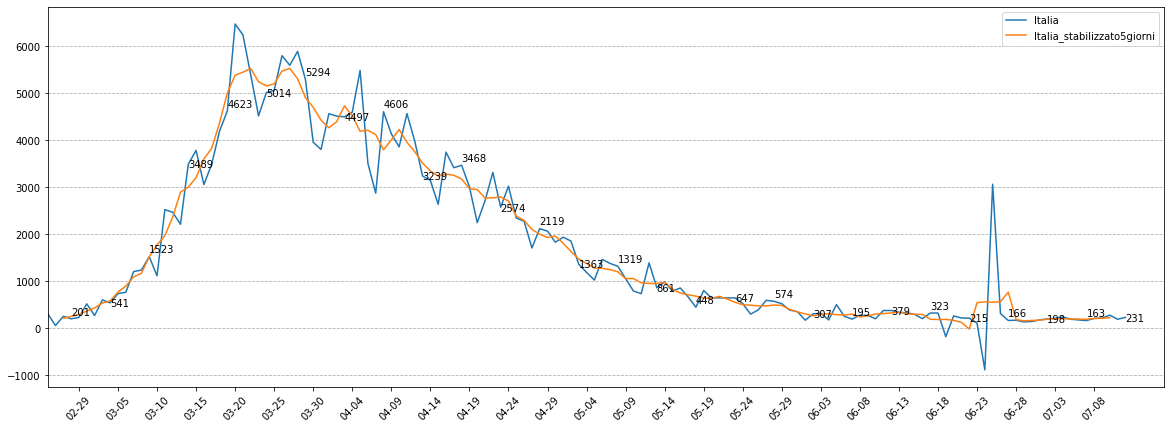

In [14]:
import os
covid_path = os.path.join(os.path.abspath('.'), 'drive', 'My Drive', 'IT', 'Python', 'covid', 'plots')
#@ title Cresciata giornaliera di contagi sull\'intero territorio Italiano
 
import requests
import pandas as pd
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')
 
rilevazioni = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')
rilevazioni['data'] = rilevazioni['data'].apply(lambda x : x[5:10])
rilevazioni = rilevazioni.drop(rilevazioni[rilevazioni['denominazione_provincia'] == 'In fase di definizione/aggiornamento'].index)
rilevazioni = rilevazioni.pivot_table(index=['denominazione_regione','denominazione_provincia'], columns='data', values='totale_casi')
rilevazioni.index.names = ['Regione', 'Provincia']
 
 
def avg_serie(dataset, day=5, add_name=True):
  avg_df = pd.DataFrame(index=dataset.index.copy())
 
  for pos in range(day-1, len(dataset.columns)):
    avg_df[dataset.columns[pos - round(day/2)]] = dataset.iloc[:,pos-day+1:pos+1].mean(axis=1)
  avg_df = avg_df.astype('int32')
  if add_name:
    if not hasattr(avg_df.index, 'levels'):
      avg_df.set_index(avg_df.index+'_stabilizzato'+str(day)+'giorni', inplace=True)
    else:
      avg_df.index.set_levels(avg_df.index.levels[1]+'_stabilizzato'+str(day)+'giorni',level=1, inplace=True)
  return avg_df
 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
 
 
def plot_annotate(df, title='', xdelta=0, ydelta=80, figsize=(17, 7), avg=False, annotation=True, path=None):
  if avg!=False:
    tmp = pd.concat([df,avg_serie(df,avg)])
  else:
    tmp = df
  ax = tmp.T.plot(figsize=figsize, title=title)
  step_size = max(round(len(df.columns) / 25 - 0.5),1)
  resto = (len(df.columns)) % step_size
  ax.set_xticks(ticks=np.arange(resto, len(df.columns) , step=step_size))
  tick_label = list(df.columns)[resto::step_size]
  ax.set_xticklabels(tick_label, rotation=45)
  ax.grid(axis='y', linestyle='--')
  ax.set_xlim(left=0, right=ax.get_xlim()[1]-2)
 
  #ax.yaxis.tick_right()
  if annotation == True:
    count = 1
    for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
      if count % step_size == resto:
        for el in v[1]:
          ax.annotate(el, (k + xdelta, el + ydelta * ( 1 if count%2 == 0 else - 1)))
      count +=1
  if path != None:
    plt.savefig(path)
  return ax
 

sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]
sorted_by_infections = sorted_by_infections.fillna(0).astype(int)
crescita = pd.DataFrame(index=sorted_by_infections.index)
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]
 
crescita_italia = crescita.sum().to_frame().T.fillna(0).astype(int)

crescita_italia.index = ['Italia']
 
 
_ = plot_annotate(crescita_italia, avg=5,path=covid_path+'/Italia.jpg', figsize=(20,7))

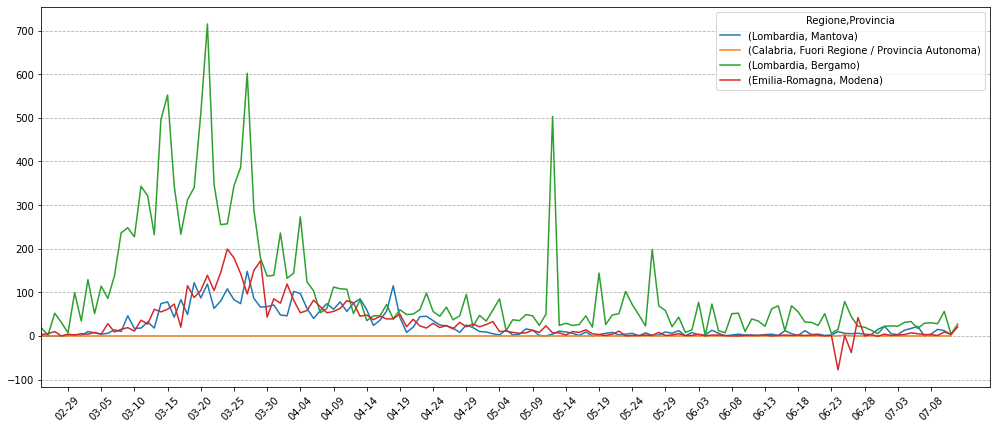

In [15]:
#@ title Crescita giornaliere di contagi per le province con maggior crescita
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(4),  ydelta=0, path=covid_path+'/Provincie-01.jpg', annotation=False)
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

In [16]:
tmp = crescita.sort_values(by=crescita.columns[-1], ascending=False).iloc[:10,-5:][:]
tmp = tmp.reorder_levels([1,0]).T
with open(covid_path+'/frame01.html', 'w') as out:
  out.write(tmp.to_html())
tmp

Provincia,Mantova,Fuori Regione / Provincia Autonoma,Bergamo,Modena,Roma,Bologna,Ferrara,Monza e della Brianza,Reggio nell'Emilia,Milano
Regione,Lombardia,Calabria,Lombardia,Emilia-Romagna,Lazio,Emilia-Romagna,Emilia-Romagna,Lombardia,Emilia-Romagna,Lombardia
07-08,4,0,30,3,7,17,0,1,6,16
07-09,15,0,28,1,30,14,0,6,-9,35
07-10,12,0,56,9,21,23,12,3,0,17
07-11,3,0,5,4,12,20,7,3,4,26
07-12,27,26,21,20,19,19,11,7,7,6


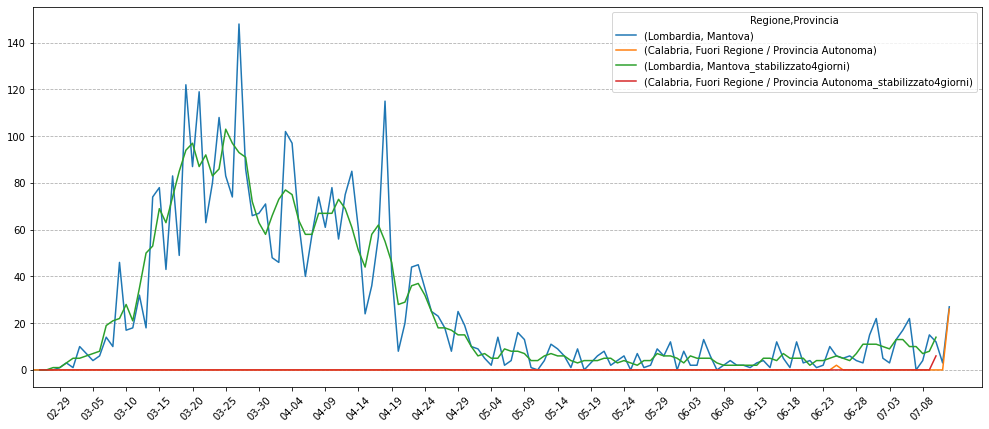

In [17]:
#@ title Crescita giornaliera di contagi mediata su un intervallo di 4 giorni per le province con maggior crescita
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(2), avg=4,  ydelta=0, path=covid_path+'/Provincie-02.jpg', annotation=False)
#_ = plot_annotate(avg_serie(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(5), day=4))

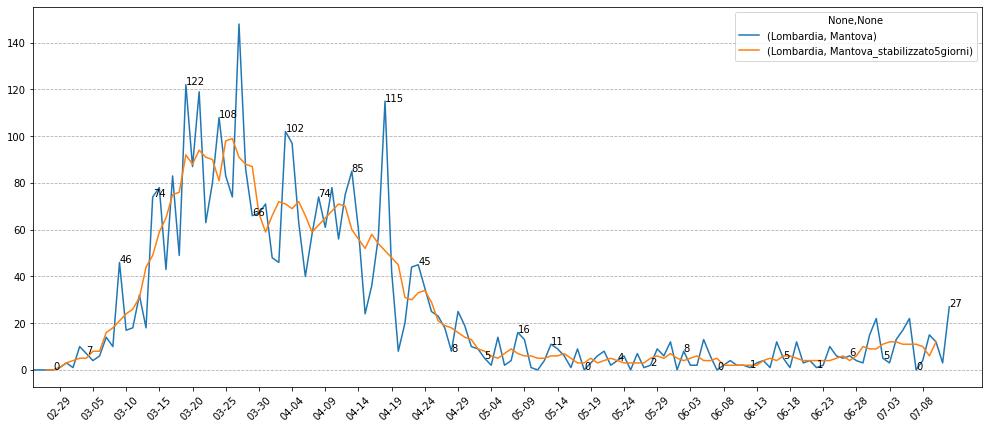

In [18]:
#@ title Crescita giornaliera di contagi a Mantova
_ = plot_annotate(crescita.loc[('Lombardia','Mantova')].to_frame().T, ydelta=0, avg=5, path=covid_path+'/Mantova.jpg')

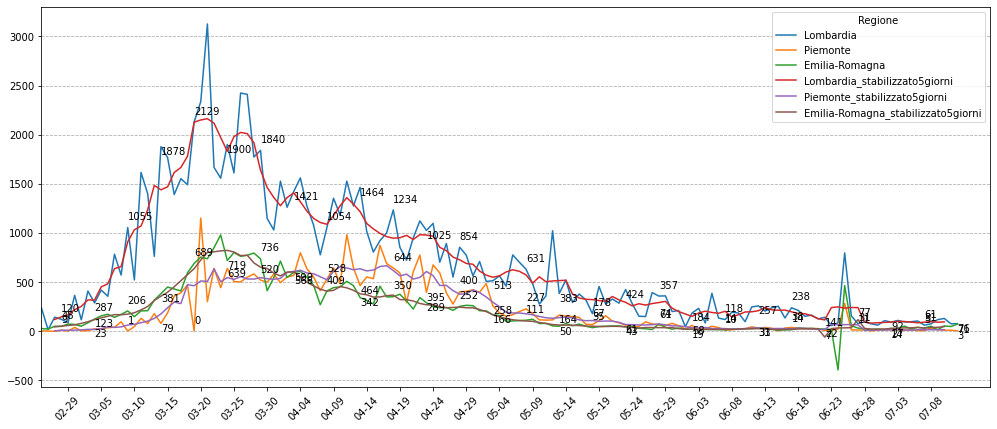

In [19]:
#@ title Crescita giornaliera per le regioni maggiormente infette
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(3), avg=5, path=covid_path+'/Regioni.jpg')


In [26]:
xx = crescita_regioni.sort_values(by=crescita_regioni.columns[-1], ascending=False).iloc[:10,-5:].T
with open(covid_path+'/frame02.html', 'w') as out:
  out.write(xx.to_html())
xx

Regione,Lombardia,Emilia-Romagna,Calabria,Lazio,Veneto,Abruzzo,P.A. Bolzano,Campania,Piemonte,Umbria
07-08,74,50,1,14,7,1,2,1,32,0
07-09,117,14,0,28,14,8,3,6,16,0
07-10,129,53,1,23,12,3,5,8,10,1
07-11,75,47,2,19,9,2,3,4,9,0
07-12,76,71,28,20,15,5,5,4,3,2


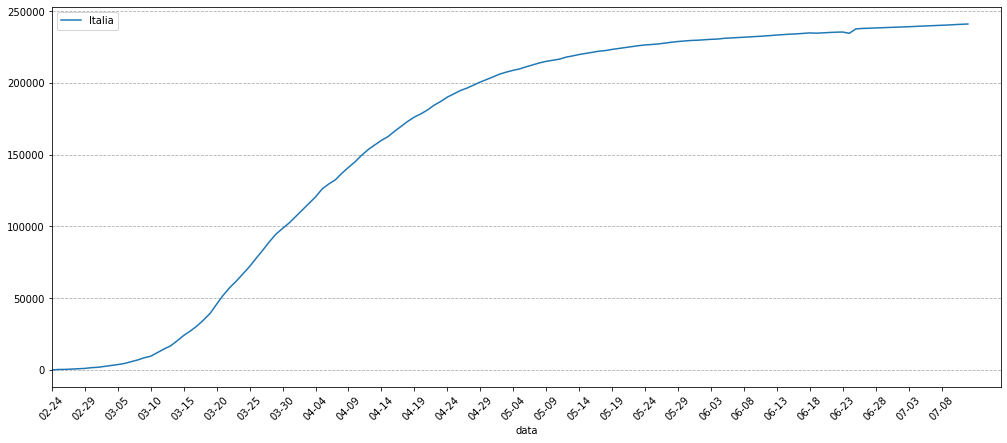

In [21]:
#@ title Contagi totali in Italia
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']
_ = plot_annotate(casi_italia, xdelta=0.5, annotation=False, path=covid_path+'/Totale Italia.jpg')

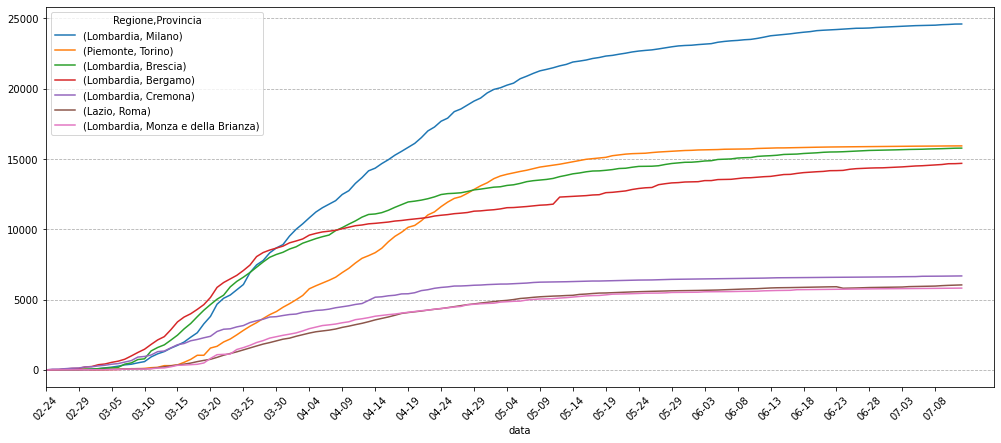

In [22]:
#@ title Contagi totali per le province maggiormente infette
_ = plot_annotate(sorted_by_infections.head(7), annotation=False, path=covid_path+'/Totale Provincie.jpg')

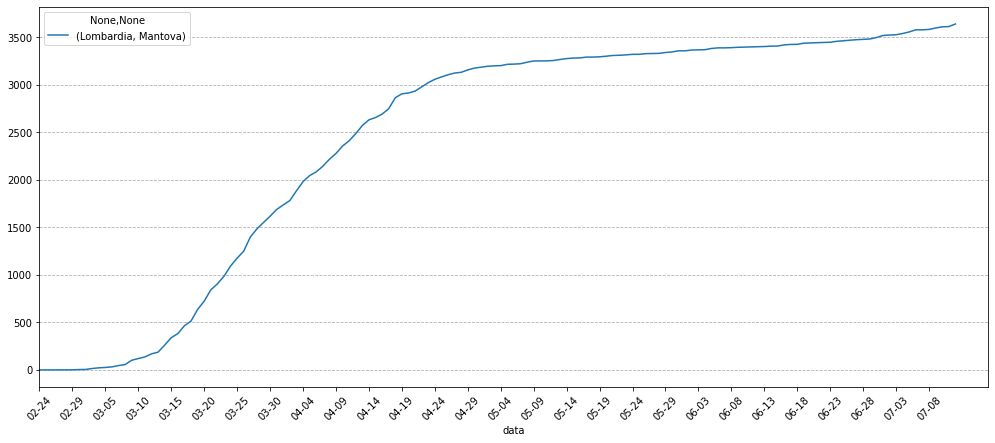

In [23]:
#@ title Contagi totali a Mantova
_ = plot_annotate(sorted_by_infections.loc[('Lombardia','Mantova')].to_frame().T, annotation=False, path=covid_path+'/Totale Mantova.jpg')

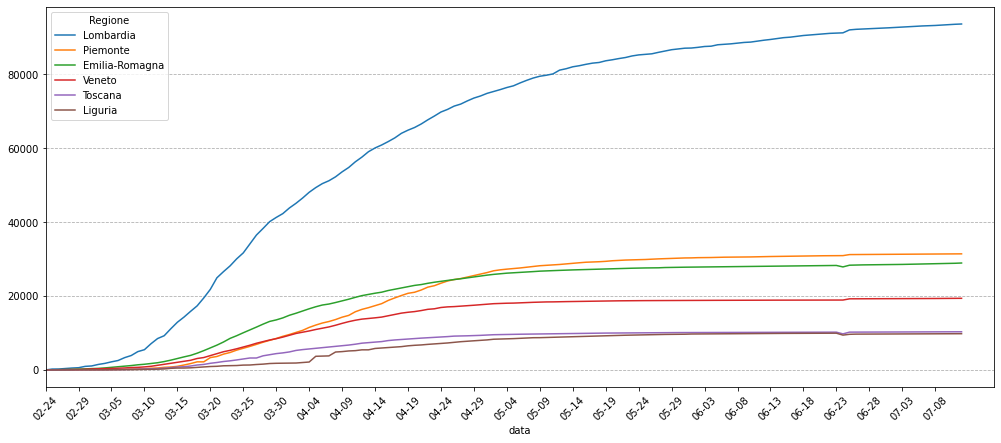

In [24]:
#@ title Contagi totali regioni
_ = plot_annotate(regioni.head(6), annotation=False, path=covid_path+'/Totale regioni.jpg')

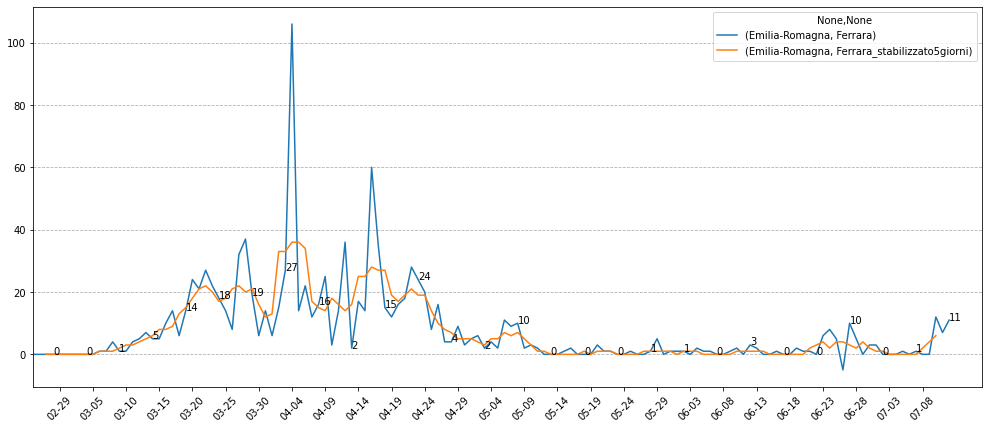

In [25]:
_ = plot_annotate(crescita.loc[('Emilia-Romagna', 'Ferrara')].to_frame().T, ydelta=0, avg=5)